In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

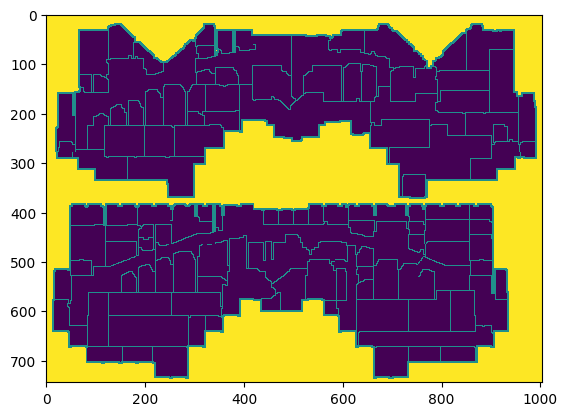

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [6]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [7]:
temp_data.shape

(53292, 123)

In [8]:
print((temp_data==0).sum()/(temp_data.shape[0]*temp_data.shape[1]))

0.10406372865800263


In [9]:
indexes1 = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_train = data['observation_value_matrix'][:, indexes1]

(temp_data_train==0).sum()/(temp_data_train.shape[0]*temp_data_train.shape[1])

0.28568066460576663

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

def kelvin_to_fahrenheit(temp_k):
    """Convert temperature from Kelvin to Fahrenheit"""
    return (temp_k - 273.15) * 9/5 + 32

def preprocess_temperatures(data_matrix, metadata_dict, data_name="data"):
    """
    Preprocess temperature data by converting Kelvin to Fahrenheit
    
    Args:
        data_matrix: numpy array of observation data
        metadata_dict: dictionary containing observation_ids mapping
        data_name: string name for logging purposes

    Returns:
        data_matrix: preprocessed data matrix (modified in-place)
        temp_conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    # Find temperature-related observation IDs
    temp_sensor_ids = []
    temp_setpoint_ids = []
    
    for obs_name, obs_idx in metadata_dict.items():
        if any(temp_keyword in obs_name.lower() for temp_keyword in [
            'temperature_sensor', 'temperature_setpoint', 
            'air_temperature', 'mixed_air_temperature',
            'supply_air_temperature', 'return_air_temperature',
            'discharge_air_temperature', 'outside_air_temperature'
        ]):
            if 'sensor' in obs_name:
                temp_sensor_ids.append((obs_name, obs_idx))
            elif 'setpoint' in obs_name:
                temp_setpoint_ids.append((obs_name, obs_idx))
            else:
                # Default to sensor if unclear
                temp_sensor_ids.append((obs_name, obs_idx))
    
    print(f"Found {len(temp_sensor_ids)} temperature sensors")
    print(f"Found {len(temp_setpoint_ids)} temperature setpoints")
    
    conversion_info = {
        'sensors_converted': 0,
        'setpoints_converted': 0,
        'total_values_converted': 0,
        'sensor_details': [],
        'setpoint_details': []
    }
    
    # Process temperature sensors
    for obs_name, obs_idx in temp_sensor_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    # Process temperature setpoints
    for obs_name, obs_idx in temp_setpoint_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['setpoints_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['setpoint_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Temperature setpoints converted: {conversion_info['setpoints_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return data_matrix, conversion_info

def preprocess_temp_data_array(temp_data_array, temp_data_ids, data_name="temperature data"):
    """
    Preprocess temperature data array (for validation temperature data)
    
    Args:
        temp_data_array: numpy array of temperature data
        temp_data_ids: dictionary mapping temperature sensor names to column indices
        data_name: string name for logging purposes

    Returns:
        temp_data_array: preprocessed temperature data (modified in-place)
        conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    conversion_info = {
        'sensors_converted': 0,
        'total_values_converted': 0,
        'sensor_details': []
    }
    
    for sensor_name, col_idx in temp_data_ids.items():
        temp_values = temp_data_array[:, col_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {sensor_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            temp_data_array[kelvin_mask, col_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={temp_data_array[kelvin_mask, col_idx].min():.2f}, max={temp_data_array[kelvin_mask, col_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': sensor_name,
                'index': col_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return temp_data_array, conversion_info

def remove_zero_temperature_readings(obs_matrix, temp_data_matrix, exog_data_matrix, 
                                   timestamps_train, timestamps_val, metadata_obs_ids, 
                                   temp_data_ids, exog_data_ids):
    """
    Remove rows where temperature sensors have zero values from both training and validation sets
    
    Args:
        obs_matrix: training observation matrix
        temp_data_matrix: validation temperature data matrix  
        exog_data_matrix: validation exogenous data matrix
        timestamps_train: training timestamps
        timestamps_val: validation timestamps
        metadata_obs_ids: training observation IDs mapping
        temp_data_ids: validation temperature IDs mapping
        exog_data_ids: validation exogenous IDs mapping

    Returns:
        Cleaned datasets with zero temperature readings removed
    """
    
    print("\n" + "="*60)
    print("REMOVING ZERO TEMPERATURE READINGS")
    print("="*60)
    
    # 1. Clean training data
    print("\nCleaning training data...")
    
    # Find temperature sensor columns in training data
    train_temp_indices = [v for k, v in metadata_obs_ids.items() 
                         if "zone_air_temperature_sensor" in k]
    
    # Get temperature data from training matrix
    train_temp_data = obs_matrix[:, train_temp_indices]
    
    # Find rows where ANY temperature sensor has zero values
    zero_mask_train = np.any(train_temp_data == 0, axis=1)
    valid_mask_train = ~zero_mask_train
    
    print(f"  Original training data: {len(obs_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_train)}")
    print(f"  Rows to keep: {np.sum(valid_mask_train)}")
    print(f"  Percentage kept: {np.sum(valid_mask_train)/len(obs_matrix)*100:.1f}%")
    
    # Apply mask to training data
    obs_matrix_clean = obs_matrix[valid_mask_train]
    timestamps_train_clean = [timestamps_train[i] for i in range(len(timestamps_train)) if valid_mask_train[i]]
    
    # 2. Clean validation data
    print("\nCleaning validation data...")
    
    # Find rows where ANY temperature sensor has zero values in validation
    zero_mask_val = np.any(temp_data_matrix == 0, axis=1)
    valid_mask_val = ~zero_mask_val
    
    print(f"  Original validation data: {len(temp_data_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_val)}")
    print(f"  Rows to keep: {np.sum(valid_mask_val)}")
    print(f"  Percentage kept: {np.sum(valid_mask_val)/len(temp_data_matrix)*100:.1f}%")
    
    # Apply mask to validation data
    temp_data_clean = temp_data_matrix[valid_mask_val]
    exog_data_clean = exog_data_matrix[valid_mask_val]
    timestamps_val_clean = [timestamps_val[i] for i in range(len(timestamps_val)) if valid_mask_val[i]]
    
    print(f"\nData cleaning summary:")
    print(f"  Training: {len(obs_matrix)} -> {len(obs_matrix_clean)} rows")
    print(f"  Validation: {len(temp_data_matrix)} -> {len(temp_data_clean)} rows")
    
    return (obs_matrix_clean, temp_data_clean, exog_data_clean, 
            timestamps_train_clean, timestamps_val_clean)

# ===== MAIN PREPROCESSING STEP =====
print("Starting temperature preprocessing...")

# First, extract arrays from NpzFile objects to make them modifiable
print("Extracting arrays from NpzFile objects...")

# Extract training observation matrix (make it modifiable)
train_obs_matrix = np.array(data['observation_value_matrix'])
print(f"Training observation matrix shape: {train_obs_matrix.shape}")

# Extract validation exogenous data (make it modifiable) 
val_exog_matrix = np.array(exogenous_observation_data)
print(f"Validation exogenous matrix shape: {val_exog_matrix.shape}")

# Extract validation temperature data (make it modifiable)
val_temp_matrix = np.array(temp_data)
print(f"Validation temperature matrix shape: {val_temp_matrix.shape}")

# 1. Preprocess training data (observation_value_matrix)
print("\n" + "="*60)
print("PREPROCESSING TRAINING DATA")
print("="*60)

train_obs_matrix, train_conversion_info = preprocess_temperatures(
    train_obs_matrix, 
    metadata['observation_ids'], 
    "training data"
)

# 2. Preprocess validation exogenous data
print("\n" + "="*60)
print("PREPROCESSING VALIDATION EXOGENOUS DATA")
print("="*60)

val_exog_matrix, val_exog_conversion_info = preprocess_temperatures(
    val_exog_matrix, 
    exogenous_observation_data_ids, 
    "validation exogenous data"
)

# 3. Preprocess validation temperature data (targets)
print("\n" + "="*60)
print("PREPROCESSING VALIDATION TEMPERATURE DATA (TARGETS)")
print("="*60)

val_temp_matrix, val_temp_conversion_info = preprocess_temp_data_array(
    val_temp_matrix, 
    temp_data_ids, 
    "validation temperature targets"
)

# 4. Remove zero temperature readings from both training and validation
print("\n" + "="*60)
print("REMOVING ZERO TEMPERATURE READINGS")
print("="*60)

# Remove rows with zero temperature readings
(train_obs_matrix_clean, val_temp_matrix_clean, val_exog_matrix_clean, 
 timestamps_train_clean, timestamps_val_clean) = remove_zero_temperature_readings(
    train_obs_matrix, val_temp_matrix, val_exog_matrix,
    metadata["observation_timestamps"], metadata_val["observation_timestamps"],
    metadata['observation_ids'], temp_data_ids, exogenous_observation_data_ids
)

print("\n" + "="*60)
print("TEMPERATURE PREPROCESSING COMPLETED")
print("="*60)

# Print overall summary
total_converted = (train_conversion_info['total_values_converted'] + 
                  val_exog_conversion_info['total_values_converted'] + 
                  val_temp_conversion_info['total_values_converted'])

print(f"\nOVERALL CONVERSION SUMMARY:")
print(f"  Training data: {train_conversion_info['total_values_converted']} values converted")
print(f"  Validation exogenous: {val_exog_conversion_info['total_values_converted']} values converted")
print(f"  Validation targets: {val_temp_conversion_info['total_values_converted']} values converted")
print(f"  TOTAL: {total_converted} temperature values converted from Kelvin to Fahrenheit")

print(f"\nOVERALL ZERO REMOVAL SUMMARY:")
print(f"  Training data: {len(train_obs_matrix)} -> {len(train_obs_matrix_clean)} rows")
print(f"  Validation data: {len(val_temp_matrix)} -> {len(val_temp_matrix_clean)} rows")

# Update the global variables to use the cleaned, preprocessed data
print("\nUpdating global variables with cleaned and preprocessed data...")
exogenous_observation_data = val_exog_matrix_clean
temp_data = val_temp_matrix_clean

print("Preprocessing complete! Now starting model training with PCA...")

# ===== MODEL WITH PCA =====

class SmartBuildingsPredictor:
    def __init__(self, use_gpu=True, n_pca_components=5):
        self.use_gpu = use_gpu
        self.n_pca_components = n_pca_components
        self.models = {}  # Will store 24 hourly models
        self.scalers = {}  # Will store scalers for each hour
        self.pca = None  # Will store PCA transformer
        self.imputer = None  # Will store imputer for NaN handling
        self.feature_columns = None
        self.temp_columns = None
        
    def interpolate_zeros(self, data):
        """Interpolate zero values in training data"""
        data_df = pd.DataFrame(data)
        # Replace zeros with NaN for interpolation
        data_df = data_df.replace(0, np.nan)
        # Forward fill then backward fill
        data_df = data_df.fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with column mean
        data_df = data_df.fillna(data_df.mean())
        return data_df.values
    
    def handle_nan_values(self, exog_data, is_training=True):
        """Handle NaN values in exogenous data"""
        nan_count = np.isnan(exog_data).sum()
        
        if is_training:
            # Always fit imputer on training data (even if no NaN values)
            # This ensures imputer is available for test data that might have NaN values
            self.imputer = SimpleImputer(strategy='mean')
            exog_data_clean = self.imputer.fit_transform(exog_data)
            print(f"Fitted imputer on training data (found {nan_count} NaN values, {nan_count/exog_data.size*100:.2f}%)")
        else:
            # Use fitted imputer on test data
            if self.imputer is None:
                raise ValueError("Imputer not fitted yet. Train model first.")
            print(f"Found {nan_count} NaN values in test data ({nan_count/exog_data.size*100:.2f}%)")
            exog_data_clean = self.imputer.transform(exog_data)
            print("Applied fitted imputer to test data")
        
        nan_count_after = np.isnan(exog_data_clean).sum()
        print(f"NaN values after imputation: {nan_count_after}")
        return exog_data_clean
    
    def create_temporal_features(self, timestamps):
        """Create temporal dummy features"""
        features = []
        
        for ts in timestamps:
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Hour of day (0-23)
            hour = dt.hour
            
            # Time of day categories
            if 6 <= hour < 12:
                time_of_day = [1, 0, 0, 0]  # morning
            elif 12 <= hour < 18:
                time_of_day = [0, 1, 0, 0]  # day
            elif 18 <= hour < 22:
                time_of_day = [0, 0, 1, 0]  # evening
            else:
                time_of_day = [0, 0, 0, 1]  # night
            
            # Season
            month = dt.month
            if month in [12, 1, 2]:
                season = [1, 0, 0, 0]  # winter
            elif month in [3, 4, 5]:
                season = [0, 1, 0, 0]  # spring
            elif month in [6, 7, 8]:
                season = [0, 0, 1, 0]  # summer
            else:
                season = [0, 0, 0, 1]  # fall
            
            # Weekend/weekday
            is_weekend = 1 if dt.weekday() >= 5 else 0
            
            # Day of week (one-hot)
            day_of_week = [0] * 7
            day_of_week[dt.weekday()] = 1
            
            # Combine all features
            feature_row = [hour] + time_of_day + season + [is_weekend] + day_of_week
            features.append(feature_row)
        
        feature_names = ['hour'] + \
                       ['morning', 'day', 'evening', 'night'] + \
                       ['winter', 'spring', 'summer', 'fall'] + \
                       ['is_weekend'] + \
                       [f'dow_{i}' for i in range(7)]
        
        return np.array(features), feature_names
    
    def fit_pca(self, exog_data):
        """Fit PCA on exogenous features"""
        print(f"Fitting PCA on exogenous features...")
        print(f"Original exogenous features: {exog_data.shape[1]}")
        
        # Fit PCA
        self.pca = PCA(n_components=self.n_pca_components, random_state=42)
        self.pca.fit(exog_data)
        
        explained_variance_ratio = np.sum(self.pca.explained_variance_ratio_)
        print(f"PCA components: {self.n_pca_components}")
        print(f"Explained variance ratio: {explained_variance_ratio:.4f}")
        
    def transform_exog_data(self, exog_data):
        """Transform exogenous data using fitted PCA"""
        if self.pca is None:
            raise ValueError("PCA not fitted yet. Call fit_pca first.")
        
        return self.pca.transform(exog_data)
    
    def prepare_data(self, obs_data, exog_data, timestamps, temp_data=None, is_training=True):
        """Prepare data with interpolation, NaN handling, PCA, and feature engineering"""
        
        # Interpolate training data
        if is_training:
            obs_data = self.interpolate_zeros(obs_data) if obs_data is not None else None
            temp_data = self.interpolate_zeros(temp_data) if temp_data is not None else None
        
        # Create temporal features
        temporal_features, temporal_names = self.create_temporal_features(timestamps)
        
        # Apply NaN handling and PCA to exogenous features
        if exog_data is not None:
            # Handle NaN values first
            exog_data_clean = self.handle_nan_values(exog_data, is_training=is_training)
            
            if is_training and self.pca is None:
                # Fit PCA on training data
                self.fit_pca(exog_data_clean)
            
            # Transform exogenous data using PCA
            exog_pca = self.transform_exog_data(exog_data_clean)
            exog_names = [f'pca_{i}' for i in range(exog_pca.shape[1])]
            
            # Combine PCA features and temporal features
            X = np.hstack([exog_pca, temporal_features])
            feature_names = exog_names + temporal_names
        else:
            X = temporal_features
            feature_names = temporal_names
        
        return X, feature_names, temp_data
    
    def create_hourly_bins(self, X, y, timestamps):
        """Create hourly bins for data"""
        hourly_data = {}
        
        for i, ts in enumerate(timestamps):
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                hour = ts.hour
            else:  # Unix timestamp
                hour = datetime.fromtimestamp(ts).hour
                
            if hour not in hourly_data:
                hourly_data[hour] = {'X': [], 'y': []}
            hourly_data[hour]['X'].append(X[i])
            if y is not None:
                hourly_data[hour]['y'].append(y[i])
        
        # Convert to numpy arrays
        for hour in hourly_data:
            hourly_data[hour]['X'] = np.array(hourly_data[hour]['X'])
            if y is not None:
                hourly_data[hour]['y'] = np.array(hourly_data[hour]['y'])
        
        return hourly_data
    
    def optimize_hyperparameters(self, X_train, y_train, trial):
        """Optuna objective function for hyperparameter optimization"""
        params = {
            'objective': 'reg:absoluteerror',  # MAE objective
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
            'random_state': 42,
            'n_jobs': 1
        }
        
        base_model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(base_model, n_jobs=1)
        
        # Simple train/validation split for optimization
        split_idx = int(0.8 * len(X_train))
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        
        return mean_absolute_error(y_val, y_pred)
    
    def train_hourly_models(self, X_train, y_train, timestamps_train, n_trials=3):
        """Train 24 hourly XGBoost models with hyperparameter optimization"""
        
        # Create hourly bins
        hourly_train_data = self.create_hourly_bins(X_train, y_train, timestamps_train)
        
        print(f"Training {len(hourly_train_data)} hourly models...")
        
        for hour in range(24):
            if hour not in hourly_train_data:
                print(f"No data for hour {hour}, skipping...")
                continue
                
            print(f"Training model for hour {hour}...")
            
            X_hour = hourly_train_data[hour]['X']
            y_hour = hourly_train_data[hour]['y']
            
            if len(X_hour) < 10:
                print(f"Too few samples for hour {hour} ({len(X_hour)}), skipping...")
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_hour_scaled = scaler.fit_transform(X_hour)
            self.scalers[hour] = scaler
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize', study_name=f'hour_{hour}')
            
            def objective(trial):
                return self.optimize_hyperparameters(X_hour_scaled, y_hour, trial)
            
            study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
            
            # Train final model with best parameters
            best_params = study.best_params
            best_params.update({
                'objective': 'reg:absoluteerror',
                'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
                'random_state': 42,
                'n_jobs': 1
            })
            
            base_model = xgb.XGBRegressor(**best_params)
            model = MultiOutputRegressor(base_model, n_jobs=1)
            model.fit(X_hour_scaled, y_hour)
            
            self.models[hour] = model
            
            print(f"Hour {hour} - Best MAE: {study.best_value:.4f}")
        
        print(f"Training completed. {len(self.models)} models trained.")
    
    def predict(self, X_test, timestamps_test):
        """Make predictions using hourly models"""
        first_model = self.models[list(self.models.keys())[0]]
        n_outputs = len(first_model.estimators_)
        
        predictions = np.zeros((len(X_test), n_outputs))
        
        # Create hourly bins for test data
        hourly_test_data = self.create_hourly_bins(X_test, None, timestamps_test)
        
        for hour in hourly_test_data:
            if hour not in self.models:
                available_hours = list(self.models.keys())
                hour_to_use = min(available_hours, key=lambda x: abs(x - hour))
                print(f"Using model for hour {hour_to_use} instead of hour {hour}")
            else:
                hour_to_use = hour
            
            X_hour = hourly_test_data[hour]['X']
            X_hour_scaled = self.scalers[hour_to_use].transform(X_hour)
            
            hour_predictions = self.models[hour_to_use].predict(X_hour_scaled)
            
            # Map predictions back to original indices
            hour_indices = []
            for i, ts in enumerate(timestamps_test):
                if hasattr(ts, 'hour'):
                    ts_hour = ts.hour
                else:
                    ts_hour = datetime.fromtimestamp(ts).hour
                    
                if ts_hour == hour:
                    hour_indices.append(i)
            
            for i, idx in enumerate(hour_indices):
                predictions[idx] = hour_predictions[i]
        
        return predictions
    
    def evaluate_predictions(self, y_true, y_pred, timestamps_test):
        """Evaluate predictions for different time periods"""
        results = {}
        
        # Convert timestamps to datetime for easier handling
        dates = []
        for ts in timestamps_test:
            if hasattr(ts, 'to_pydatetime'):
                dates.append(ts.to_pydatetime())
            elif hasattr(ts, 'hour'):
                dates.append(ts)
            else:
                dates.append(datetime.fromtimestamp(ts))
        
        start_date = min(dates)
        
        # Define evaluation periods
        periods = {
            'first_week': timedelta(days=7),
            'first_2_weeks': timedelta(days=14),
            'first_month': timedelta(days=30),
            'first_3_months': timedelta(days=90),
            'entire_period': timedelta(days=365)
        }
        
        for period_name, period_length in periods.items():
            end_date = start_date + period_length
            
            period_indices = [i for i, date in enumerate(dates) if date <= end_date]
            
            if period_indices:
                y_true_period = y_true[period_indices]
                y_pred_period = y_pred[period_indices]
                
                mae = mean_absolute_error(y_true_period, y_pred_period)
                results[period_name] = mae
                print(f"{period_name}: MAE = {mae:.4f}")
        
        return results

# Main execution function
def run_smart_buildings_model():
    """Main function to run the complete model"""
    
    print("Initializing Smart Buildings Predictor with PCA and NaN handling...")
    predictor = SmartBuildingsPredictor(use_gpu=True, n_pca_components=5)
    
    # Prepare training data
    print("Preparing training data...")
    
    # Extract training temperature data (target) from cleaned preprocessed data
    train_temp_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" in k]
    train_temp_data = train_obs_matrix_clean[:, train_temp_indices]
    
    # Extract training exogenous data from cleaned preprocessed data
    train_exog_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" not in k]
    train_exog_data = train_obs_matrix_clean[:, train_exog_indices]
    
    # Prepare training features and targets using cleaned timestamps
    X_train, feature_names, y_train = predictor.prepare_data(
        None, train_exog_data, timestamps_train_clean, 
        train_temp_data, is_training=True
    )
    
    predictor.feature_columns = feature_names
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Feature names: {len(feature_names)} features")
    
    # Train models using cleaned timestamps with 5 trials
    predictor.train_hourly_models(X_train, y_train, timestamps_train_clean, n_trials=3)
    
    # Prepare test data using cleaned validation data
    print("Preparing test data...")
    X_test, _, _ = predictor.prepare_data(
        None, exogenous_observation_data, timestamps_val_clean, 
        None, is_training=False
    )
    
    print(f"Test data shape: {X_test.shape}")
    
    # Make predictions using cleaned validation timestamps
    print("Making predictions...")
    predictions = predictor.predict(X_test, timestamps_val_clean)
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"True values shape: {temp_data.shape}")
    
    # Evaluate results using cleaned validation timestamps
    print("\nEvaluation Results:")
    print("=" * 50)
    results = predictor.evaluate_predictions(
        temp_data, predictions, timestamps_val_clean
    )
    
    return predictor, predictions, results

# Run the model
if __name__ == "__main__":
    predictor, predictions, results = run_smart_buildings_model()

Starting temperature preprocessing...
Extracting arrays from NpzFile objects...
Training observation matrix shape: (51852, 1198)
Validation exogenous matrix shape: (53292, 1075)
Validation temperature matrix shape: (53292, 123)

PREPROCESSING TRAINING DATA

=== Temperature Preprocessing for training data ===
Found 246 temperature sensors
Found 357 temperature setpoints
  Converting 36921/51852 values in 202194278473007104@return_air_temperature_sensor
    Before: min=284.43, max=307.39
    After:  min=52.30, max=93.64
  Converting 36921/51852 values in 202194278473007104@mixed_air_temperature_sensor
    Before: min=281.87, max=305.57
    After:  min=47.69, max=90.35
  Converting 36921/51852 values in 202194278473007104@supply_air_temperature_sensor
    Before: min=280.11, max=305.19
    After:  min=44.53, max=89.67
  Converting 36758/51852 values in 2291864505572917248@outside_air_wetbulb_temperature_sensor
    Before: min=273.01, max=293.60
    After:  min=31.74, max=68.82
  Convertin

[I 2025-07-04 18:56:56,572] A new study created in memory with name: hour_0


Training 24 hourly models...
Training model for hour 0...


[I 2025-07-04 19:00:01,985] Trial 0 finished with value: 1.6248948008927042 and parameters: {'n_estimators': 386, 'max_depth': 7, 'learning_rate': 0.11327859918657017, 'subsample': 0.7593697046880541, 'colsample_bytree': 0.7264548266416202, 'reg_alpha': 6.984402834682721, 'reg_lambda': 1.1821255307490874}. Best is trial 0 with value: 1.6248948008927042.
[I 2025-07-04 19:02:40,562] Trial 1 finished with value: 1.670613511479844 and parameters: {'n_estimators': 362, 'max_depth': 6, 'learning_rate': 0.28344929776626665, 'subsample': 0.9255420510719391, 'colsample_bytree': 0.6813007908199709, 'reg_alpha': 3.6994956672916843, 'reg_lambda': 4.359497488952522}. Best is trial 0 with value: 1.6248948008927042.
[I 2025-07-04 19:03:49,516] Trial 2 finished with value: 1.7200440139054132 and parameters: {'n_estimators': 175, 'max_depth': 5, 'learning_rate': 0.23316563611157318, 'subsample': 0.6935558784430785, 'colsample_bytree': 0.7303176032992321, 'reg_alpha': 6.16480842806465, 'reg_lambda': 0.2

Hour 0 - Best MAE: 1.6249
Training model for hour 1...


[I 2025-07-04 19:08:35,789] Trial 0 finished with value: 2.0363088024379215 and parameters: {'n_estimators': 223, 'max_depth': 6, 'learning_rate': 0.10819871567987689, 'subsample': 0.9870427896653604, 'colsample_bytree': 0.8097141765414463, 'reg_alpha': 7.474131036974529, 'reg_lambda': 8.707326403243014}. Best is trial 0 with value: 2.0363088024379215.
[I 2025-07-04 19:10:59,193] Trial 1 finished with value: 2.068406961083508 and parameters: {'n_estimators': 294, 'max_depth': 7, 'learning_rate': 0.06652927091682183, 'subsample': 0.7049422833627906, 'colsample_bytree': 0.8718449576326769, 'reg_alpha': 7.699059313420213, 'reg_lambda': 9.416401858817276}. Best is trial 0 with value: 2.0363088024379215.
[I 2025-07-04 19:13:03,264] Trial 2 finished with value: 2.085042349058479 and parameters: {'n_estimators': 311, 'max_depth': 5, 'learning_rate': 0.17507549576963588, 'subsample': 0.62146672589047, 'colsample_bytree': 0.7518207416065524, 'reg_alpha': 3.2709945973555072, 'reg_lambda': 3.2622

Hour 1 - Best MAE: 2.0363
Training model for hour 2...


[I 2025-07-04 19:16:44,458] Trial 0 finished with value: 2.0469976132287067 and parameters: {'n_estimators': 420, 'max_depth': 3, 'learning_rate': 0.18738996146094605, 'subsample': 0.7540574324919792, 'colsample_bytree': 0.9545098095740919, 'reg_alpha': 2.1584668562382, 'reg_lambda': 4.859942480469196}. Best is trial 0 with value: 2.0469976132287067.
[I 2025-07-04 19:17:51,896] Trial 1 finished with value: 2.0973085766391186 and parameters: {'n_estimators': 134, 'max_depth': 7, 'learning_rate': 0.05597137341662866, 'subsample': 0.6852805293601677, 'colsample_bytree': 0.9733518867158505, 'reg_alpha': 5.477556817351342, 'reg_lambda': 6.873507730673408}. Best is trial 0 with value: 2.0469976132287067.
[I 2025-07-04 19:20:29,323] Trial 2 finished with value: 2.1306487828050167 and parameters: {'n_estimators': 409, 'max_depth': 5, 'learning_rate': 0.17661828269378524, 'subsample': 0.7732367211485537, 'colsample_bytree': 0.7249884117825711, 'reg_alpha': 8.102288743594691, 'reg_lambda': 2.247

Hour 2 - Best MAE: 2.0470
Training model for hour 3...


[I 2025-07-04 19:23:29,974] Trial 0 finished with value: 2.5304976834981123 and parameters: {'n_estimators': 137, 'max_depth': 6, 'learning_rate': 0.18533605169170242, 'subsample': 0.6977189297457427, 'colsample_bytree': 0.6328784383977399, 'reg_alpha': 9.81216379489148, 'reg_lambda': 3.2763644241869336}. Best is trial 0 with value: 2.5304976834981123.
[I 2025-07-04 19:24:36,428] Trial 1 finished with value: 2.4401303567976993 and parameters: {'n_estimators': 222, 'max_depth': 3, 'learning_rate': 0.03665940310327254, 'subsample': 0.7957424179841754, 'colsample_bytree': 0.9659499581817996, 'reg_alpha': 5.348228957155964, 'reg_lambda': 9.179380882062194}. Best is trial 1 with value: 2.4401303567976993.
[I 2025-07-04 19:27:43,370] Trial 2 finished with value: 2.347395458896313 and parameters: {'n_estimators': 430, 'max_depth': 6, 'learning_rate': 0.013679346129207392, 'subsample': 0.6678661070352282, 'colsample_bytree': 0.9928642518284833, 'reg_alpha': 2.871177655957927, 'reg_lambda': 9.3

Hour 3 - Best MAE: 2.3474
Training model for hour 4...


[I 2025-07-04 19:32:53,217] Trial 0 finished with value: 2.778562860970149 and parameters: {'n_estimators': 224, 'max_depth': 8, 'learning_rate': 0.15173131733390857, 'subsample': 0.6488241941263425, 'colsample_bytree': 0.8811394228836099, 'reg_alpha': 4.6417546560956, 'reg_lambda': 0.5847892307109108}. Best is trial 0 with value: 2.778562860970149.
[I 2025-07-04 19:37:15,972] Trial 1 finished with value: 2.809969816474224 and parameters: {'n_estimators': 499, 'max_depth': 8, 'learning_rate': 0.181544225221658, 'subsample': 0.6155313755435613, 'colsample_bytree': 0.9072892079497135, 'reg_alpha': 5.179026333335234, 'reg_lambda': 3.606722371183609}. Best is trial 0 with value: 2.778562860970149.
[I 2025-07-04 19:38:42,937] Trial 2 finished with value: 2.8397016486822317 and parameters: {'n_estimators': 291, 'max_depth': 3, 'learning_rate': 0.21437769420316097, 'subsample': 0.7576019665628633, 'colsample_bytree': 0.7260071777302605, 'reg_alpha': 9.333397407494688, 'reg_lambda': 6.13976507

Hour 4 - Best MAE: 2.7786
Training model for hour 5...


[I 2025-07-04 19:41:22,420] Trial 0 finished with value: 2.919152648039177 and parameters: {'n_estimators': 104, 'max_depth': 4, 'learning_rate': 0.10909732328848075, 'subsample': 0.8278615726596943, 'colsample_bytree': 0.9348792391093257, 'reg_alpha': 4.862320468819561, 'reg_lambda': 7.764737117572538}. Best is trial 0 with value: 2.919152648039177.
[I 2025-07-04 19:45:57,163] Trial 1 finished with value: 2.742018361827649 and parameters: {'n_estimators': 466, 'max_depth': 8, 'learning_rate': 0.13391520722962882, 'subsample': 0.9103029200305669, 'colsample_bytree': 0.9295195859821066, 'reg_alpha': 1.981251832459294, 'reg_lambda': 5.394679418652434}. Best is trial 1 with value: 2.742018361827649.
[I 2025-07-04 19:47:14,048] Trial 2 finished with value: 2.9827988965713694 and parameters: {'n_estimators': 256, 'max_depth': 3, 'learning_rate': 0.11826389354057668, 'subsample': 0.6780434866887394, 'colsample_bytree': 0.8306632631875668, 'reg_alpha': 2.174926886655855, 'reg_lambda': 0.42645

Hour 5 - Best MAE: 2.7420
Training model for hour 6...


[I 2025-07-04 19:54:29,197] Trial 0 finished with value: 2.7372052851948094 and parameters: {'n_estimators': 354, 'max_depth': 8, 'learning_rate': 0.1979806711122272, 'subsample': 0.6151738812154539, 'colsample_bytree': 0.9438256043497232, 'reg_alpha': 6.802786927837255, 'reg_lambda': 0.8956553621815171}. Best is trial 0 with value: 2.7372052851948094.
[I 2025-07-04 19:55:03,974] Trial 1 finished with value: 3.6027418513164915 and parameters: {'n_estimators': 119, 'max_depth': 3, 'learning_rate': 0.022661775707828707, 'subsample': 0.8222703471600149, 'colsample_bytree': 0.8132788756384384, 'reg_alpha': 8.675341002492914, 'reg_lambda': 8.137195914850174}. Best is trial 0 with value: 2.7372052851948094.
[I 2025-07-04 19:57:48,323] Trial 2 finished with value: 2.764725367687975 and parameters: {'n_estimators': 456, 'max_depth': 5, 'learning_rate': 0.16012813942729676, 'subsample': 0.6810166969316966, 'colsample_bytree': 0.8511269707136004, 'reg_alpha': 0.9845460353587316, 'reg_lambda': 1.

Hour 6 - Best MAE: 2.7372
Training model for hour 7...


[I 2025-07-04 20:01:48,016] Trial 0 finished with value: 3.4242813598316406 and parameters: {'n_estimators': 184, 'max_depth': 4, 'learning_rate': 0.10085006239372843, 'subsample': 0.7993087589312537, 'colsample_bytree': 0.6804194624508384, 'reg_alpha': 8.179794622235706, 'reg_lambda': 4.622890325476553}. Best is trial 0 with value: 3.4242813598316406.
[I 2025-07-04 20:03:04,144] Trial 1 finished with value: 3.2779927565519884 and parameters: {'n_estimators': 275, 'max_depth': 3, 'learning_rate': 0.02720528313904067, 'subsample': 0.6136686457646551, 'colsample_bytree': 0.8074151936485143, 'reg_alpha': 8.607744801589305, 'reg_lambda': 0.17179034133510449}. Best is trial 1 with value: 3.2779927565519884.
[I 2025-07-04 20:04:13,759] Trial 2 finished with value: 3.2040719306975847 and parameters: {'n_estimators': 251, 'max_depth': 3, 'learning_rate': 0.14485766102145034, 'subsample': 0.8543031285108327, 'colsample_bytree': 0.9349717637113095, 'reg_alpha': 9.268742015085753, 'reg_lambda': 7

Hour 7 - Best MAE: 3.2041
Training model for hour 8...


[I 2025-07-04 20:07:30,598] Trial 0 finished with value: 2.9818273527449755 and parameters: {'n_estimators': 413, 'max_depth': 4, 'learning_rate': 0.2266623938809833, 'subsample': 0.6787873700903836, 'colsample_bytree': 0.9130347931625359, 'reg_alpha': 4.626137452468591, 'reg_lambda': 5.924698988588457}. Best is trial 0 with value: 2.9818273527449755.
[I 2025-07-04 20:09:37,760] Trial 1 finished with value: 3.2812759098929516 and parameters: {'n_estimators': 403, 'max_depth': 4, 'learning_rate': 0.1823830811710966, 'subsample': 0.8865054057317641, 'colsample_bytree': 0.6289100097232193, 'reg_alpha': 3.5008738847594585, 'reg_lambda': 2.2922219968217847}. Best is trial 0 with value: 2.9818273527449755.
[I 2025-07-04 20:11:38,171] Trial 2 finished with value: 2.9534980781970313 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.11391186499881349, 'subsample': 0.6889675082577787, 'colsample_bytree': 0.7885122230381876, 'reg_alpha': 0.44098681714131044, 'reg_lambda': 3

Hour 8 - Best MAE: 2.9535
Training model for hour 9...


[I 2025-07-04 20:16:25,642] Trial 0 finished with value: 3.564995253478673 and parameters: {'n_estimators': 469, 'max_depth': 5, 'learning_rate': 0.26185130787088207, 'subsample': 0.7347077090810673, 'colsample_bytree': 0.6208044836201794, 'reg_alpha': 5.143369464387756, 'reg_lambda': 3.7981772209275944}. Best is trial 0 with value: 3.564995253478673.
[I 2025-07-04 20:17:48,133] Trial 1 finished with value: 3.5322704315764466 and parameters: {'n_estimators': 242, 'max_depth': 4, 'learning_rate': 0.07947441200809391, 'subsample': 0.8691329534794765, 'colsample_bytree': 0.6102881591857319, 'reg_alpha': 6.675317116324833, 'reg_lambda': 3.374683660399165}. Best is trial 1 with value: 3.5322704315764466.
[I 2025-07-04 20:19:19,863] Trial 2 finished with value: 3.468283789269258 and parameters: {'n_estimators': 265, 'max_depth': 4, 'learning_rate': 0.06900280809602202, 'subsample': 0.7300182617063202, 'colsample_bytree': 0.7281240429344411, 'reg_alpha': 3.024776416063458, 'reg_lambda': 1.374

Hour 9 - Best MAE: 3.4683
Training model for hour 10...


[I 2025-07-04 20:22:26,115] Trial 0 finished with value: 3.688695480185777 and parameters: {'n_estimators': 284, 'max_depth': 4, 'learning_rate': 0.10815082603492326, 'subsample': 0.9880195640710343, 'colsample_bytree': 0.8479098410824472, 'reg_alpha': 6.536803735795857, 'reg_lambda': 2.9145624355983104}. Best is trial 0 with value: 3.688695480185777.
[I 2025-07-04 20:23:53,268] Trial 1 finished with value: 3.6369378077043786 and parameters: {'n_estimators': 221, 'max_depth': 5, 'learning_rate': 0.14693077227970766, 'subsample': 0.8337934852107516, 'colsample_bytree': 0.8111819707038723, 'reg_alpha': 1.5578732040809207, 'reg_lambda': 5.612431323206223}. Best is trial 1 with value: 3.6369378077043786.
[I 2025-07-04 20:26:08,389] Trial 2 finished with value: 3.7757226999231612 and parameters: {'n_estimators': 265, 'max_depth': 7, 'learning_rate': 0.20722517180335318, 'subsample': 0.6815005773410802, 'colsample_bytree': 0.6176348759242998, 'reg_alpha': 0.4776761285094904, 'reg_lambda': 5.

Hour 10 - Best MAE: 3.6369
Training model for hour 11...


[I 2025-07-04 20:28:44,280] Trial 0 finished with value: 3.473903189978642 and parameters: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.12405549070704189, 'subsample': 0.7080759664733971, 'colsample_bytree': 0.8904814304490105, 'reg_alpha': 7.648931974607764, 'reg_lambda': 2.695263026501482}. Best is trial 0 with value: 3.473903189978642.
[I 2025-07-04 20:29:50,723] Trial 1 finished with value: 3.33758673449587 and parameters: {'n_estimators': 195, 'max_depth': 4, 'learning_rate': 0.2562210393876376, 'subsample': 0.9749819112000145, 'colsample_bytree': 0.9468280843875344, 'reg_alpha': 9.374959367430822, 'reg_lambda': 6.766960702211149}. Best is trial 1 with value: 3.33758673449587.
[I 2025-07-04 20:32:43,456] Trial 2 finished with value: 3.2916092442915286 and parameters: {'n_estimators': 458, 'max_depth': 5, 'learning_rate': 0.04425024497648267, 'subsample': 0.6524789835661327, 'colsample_bytree': 0.9587741020613431, 'reg_alpha': 4.260315508183178, 'reg_lambda': 3.84479941

Hour 11 - Best MAE: 3.2916
Training model for hour 12...


[I 2025-07-04 20:37:09,079] Trial 0 finished with value: 4.104440758877488 and parameters: {'n_estimators': 161, 'max_depth': 8, 'learning_rate': 0.17592014034379722, 'subsample': 0.6740687340478133, 'colsample_bytree': 0.8732850782617156, 'reg_alpha': 7.719123779722768, 'reg_lambda': 5.721953762203815}. Best is trial 0 with value: 4.104440758877488.
[I 2025-07-04 20:38:20,309] Trial 1 finished with value: 4.017069637690544 and parameters: {'n_estimators': 179, 'max_depth': 5, 'learning_rate': 0.09301824529287187, 'subsample': 0.9091123629541799, 'colsample_bytree': 0.8181519238494444, 'reg_alpha': 6.408469863162676, 'reg_lambda': 6.577273557769241}. Best is trial 1 with value: 4.017069637690544.
[I 2025-07-04 20:39:59,151] Trial 2 finished with value: 4.179272207678607 and parameters: {'n_estimators': 290, 'max_depth': 4, 'learning_rate': 0.014720348037082664, 'subsample': 0.6989472972801463, 'colsample_bytree': 0.9831885135155612, 'reg_alpha': 0.3598072260650876, 'reg_lambda': 2.4034

Hour 12 - Best MAE: 4.0171
Training model for hour 13...


[I 2025-07-04 20:43:19,431] Trial 0 finished with value: 2.5061306380537567 and parameters: {'n_estimators': 335, 'max_depth': 5, 'learning_rate': 0.16879075078525754, 'subsample': 0.9618510448014477, 'colsample_bytree': 0.9828226196401175, 'reg_alpha': 2.1112326869791236, 'reg_lambda': 7.467955798100515}. Best is trial 0 with value: 2.5061306380537567.
[I 2025-07-04 20:45:11,306] Trial 1 finished with value: 2.188385294156868 and parameters: {'n_estimators': 381, 'max_depth': 3, 'learning_rate': 0.1356942416324608, 'subsample': 0.7255030568516969, 'colsample_bytree': 0.9788301486894967, 'reg_alpha': 1.7171771336763073, 'reg_lambda': 1.4852037231394464}. Best is trial 1 with value: 2.188385294156868.
[I 2025-07-04 20:47:53,370] Trial 2 finished with value: 2.6989522531764973 and parameters: {'n_estimators': 319, 'max_depth': 7, 'learning_rate': 0.13196189860334345, 'subsample': 0.6407497355471355, 'colsample_bytree': 0.8469254490151183, 'reg_alpha': 1.1912492968882427, 'reg_lambda': 0.

Hour 13 - Best MAE: 2.1884
Training model for hour 14...


[I 2025-07-04 20:53:26,261] Trial 0 finished with value: 2.030277919723927 and parameters: {'n_estimators': 437, 'max_depth': 7, 'learning_rate': 0.13873932567607816, 'subsample': 0.9926022979105653, 'colsample_bytree': 0.6926077294144393, 'reg_alpha': 6.79327678719691, 'reg_lambda': 8.239432418947548}. Best is trial 0 with value: 2.030277919723927.
[I 2025-07-04 20:54:33,271] Trial 1 finished with value: 2.0567296018084096 and parameters: {'n_estimators': 110, 'max_depth': 8, 'learning_rate': 0.07346497490978983, 'subsample': 0.9241115020275024, 'colsample_bytree': 0.7820031653332824, 'reg_alpha': 2.5925386384643443, 'reg_lambda': 9.737341410945106}. Best is trial 0 with value: 2.030277919723927.
[I 2025-07-04 20:56:58,906] Trial 2 finished with value: 1.978950168366361 and parameters: {'n_estimators': 431, 'max_depth': 4, 'learning_rate': 0.12963256986944313, 'subsample': 0.8040151949841894, 'colsample_bytree': 0.9290457361696146, 'reg_alpha': 2.7569439548873707, 'reg_lambda': 3.3286

Hour 14 - Best MAE: 1.9790
Training model for hour 15...


[I 2025-07-04 21:01:00,083] Trial 0 finished with value: 1.962069349990942 and parameters: {'n_estimators': 246, 'max_depth': 5, 'learning_rate': 0.18007693323917934, 'subsample': 0.9819398299355913, 'colsample_bytree': 0.9985219245555468, 'reg_alpha': 4.85403475426478, 'reg_lambda': 5.135155384043085}. Best is trial 0 with value: 1.962069349990942.
[I 2025-07-04 21:02:21,158] Trial 1 finished with value: 1.7937639064533164 and parameters: {'n_estimators': 168, 'max_depth': 7, 'learning_rate': 0.04314565046231329, 'subsample': 0.6257503326557687, 'colsample_bytree': 0.8496203718888227, 'reg_alpha': 8.604572463529866, 'reg_lambda': 1.3965981325855865}. Best is trial 1 with value: 1.7937639064533164.
[I 2025-07-04 21:05:18,248] Trial 2 finished with value: 2.2509571051257073 and parameters: {'n_estimators': 458, 'max_depth': 5, 'learning_rate': 0.25331939463916997, 'subsample': 0.7576274600314752, 'colsample_bytree': 0.6656092104581964, 'reg_alpha': 3.2012196565748625, 'reg_lambda': 8.72

Hour 15 - Best MAE: 1.7938
Training model for hour 16...


[I 2025-07-04 21:10:04,923] Trial 0 finished with value: 1.4835653096822679 and parameters: {'n_estimators': 352, 'max_depth': 8, 'learning_rate': 0.07563195277833323, 'subsample': 0.9755457076478166, 'colsample_bytree': 0.8792918255968117, 'reg_alpha': 5.281089751053206, 'reg_lambda': 0.8137646231107676}. Best is trial 0 with value: 1.4835653096822679.
[I 2025-07-04 21:13:15,895] Trial 1 finished with value: 1.3282572781671222 and parameters: {'n_estimators': 482, 'max_depth': 5, 'learning_rate': 0.05267473080353944, 'subsample': 0.6947384084623089, 'colsample_bytree': 0.9396706107187118, 'reg_alpha': 5.463090392092432, 'reg_lambda': 4.213023169301833}. Best is trial 1 with value: 1.3282572781671222.
[I 2025-07-04 21:16:26,609] Trial 2 finished with value: 1.3996488762335213 and parameters: {'n_estimators': 323, 'max_depth': 8, 'learning_rate': 0.027636813623028396, 'subsample': 0.843194066816243, 'colsample_bytree': 0.8174232812498555, 'reg_alpha': 0.37204057125595136, 'reg_lambda': 

Hour 16 - Best MAE: 1.3283
Training model for hour 17...


[I 2025-07-04 21:22:48,008] Trial 0 finished with value: 1.707263535228202 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.1655297839964863, 'subsample': 0.6118373420724088, 'colsample_bytree': 0.8391171124891781, 'reg_alpha': 2.4075870427094896, 'reg_lambda': 0.5304096639642784}. Best is trial 0 with value: 1.707263535228202.
[I 2025-07-04 21:24:35,815] Trial 1 finished with value: 2.0038635403144647 and parameters: {'n_estimators': 355, 'max_depth': 3, 'learning_rate': 0.24129176753978082, 'subsample': 0.8795423624669929, 'colsample_bytree': 0.7561790885691831, 'reg_alpha': 4.736620135859581, 'reg_lambda': 2.0077576988350585}. Best is trial 0 with value: 1.707263535228202.
[I 2025-07-04 21:26:34,821] Trial 2 finished with value: 1.71609579087751 and parameters: {'n_estimators': 232, 'max_depth': 7, 'learning_rate': 0.05214064890546019, 'subsample': 0.8659435452011615, 'colsample_bytree': 0.8572993062654535, 'reg_alpha': 0.4994717102765704, 'reg_lambda': 0.867

Hour 17 - Best MAE: 1.7073
Training model for hour 18...


[I 2025-07-04 21:32:14,968] Trial 0 finished with value: 1.7438557528592502 and parameters: {'n_estimators': 257, 'max_depth': 8, 'learning_rate': 0.22419174950283038, 'subsample': 0.955929045301246, 'colsample_bytree': 0.8955599148232767, 'reg_alpha': 5.042217558878765, 'reg_lambda': 7.462052436719707}. Best is trial 0 with value: 1.7438557528592502.
[I 2025-07-04 21:34:02,937] Trial 1 finished with value: 1.717584424526915 and parameters: {'n_estimators': 205, 'max_depth': 7, 'learning_rate': 0.15892180928748964, 'subsample': 0.8419680797260731, 'colsample_bytree': 0.7389832903927318, 'reg_alpha': 0.22518073520064436, 'reg_lambda': 9.517521862184022}. Best is trial 1 with value: 1.717584424526915.
[I 2025-07-04 21:36:13,381] Trial 2 finished with value: 1.6555967892159955 and parameters: {'n_estimators': 232, 'max_depth': 8, 'learning_rate': 0.01430068189736262, 'subsample': 0.8605664624428928, 'colsample_bytree': 0.9721212331779533, 'reg_alpha': 2.9495846714752623, 'reg_lambda': 6.6

Hour 18 - Best MAE: 1.6556
Training model for hour 19...


[I 2025-07-04 21:39:03,567] Trial 0 finished with value: 1.773851505361397 and parameters: {'n_estimators': 107, 'max_depth': 4, 'learning_rate': 0.10185131488973749, 'subsample': 0.7951153751229284, 'colsample_bytree': 0.971075727077954, 'reg_alpha': 0.8622847386221699, 'reg_lambda': 9.723447626976517}. Best is trial 0 with value: 1.773851505361397.
[I 2025-07-04 21:42:39,050] Trial 1 finished with value: 1.7034170313401331 and parameters: {'n_estimators': 443, 'max_depth': 7, 'learning_rate': 0.15428513493915627, 'subsample': 0.7682196193426671, 'colsample_bytree': 0.8349735557928288, 'reg_alpha': 8.795977716881179, 'reg_lambda': 1.770204493021598}. Best is trial 1 with value: 1.7034170313401331.
[I 2025-07-04 21:44:21,000] Trial 2 finished with value: 1.9098941438154555 and parameters: {'n_estimators': 259, 'max_depth': 5, 'learning_rate': 0.25875421338853666, 'subsample': 0.7361544871007404, 'colsample_bytree': 0.6554632198123115, 'reg_alpha': 7.772278576897169, 'reg_lambda': 2.201

Hour 19 - Best MAE: 1.7034
Training model for hour 20...


[I 2025-07-04 21:49:45,584] Trial 0 finished with value: 1.994436487722577 and parameters: {'n_estimators': 184, 'max_depth': 8, 'learning_rate': 0.23350644787672192, 'subsample': 0.8379220598639339, 'colsample_bytree': 0.7696895338598346, 'reg_alpha': 5.371649041132692, 'reg_lambda': 7.688328109405625}. Best is trial 0 with value: 1.994436487722577.
[I 2025-07-04 21:50:26,086] Trial 1 finished with value: 2.177461277617995 and parameters: {'n_estimators': 128, 'max_depth': 3, 'learning_rate': 0.2953939152943315, 'subsample': 0.6478814328359853, 'colsample_bytree': 0.6174534574809845, 'reg_alpha': 9.83426341853156, 'reg_lambda': 0.013004667079549665}. Best is trial 0 with value: 1.994436487722577.
[I 2025-07-04 21:52:53,273] Trial 2 finished with value: 1.9644593504059358 and parameters: {'n_estimators': 296, 'max_depth': 7, 'learning_rate': 0.19964001308009754, 'subsample': 0.8778153895819769, 'colsample_bytree': 0.8724979509216897, 'reg_alpha': 8.857358701116762, 'reg_lambda': 2.9688

Hour 20 - Best MAE: 1.9645
Training model for hour 21...


[I 2025-07-04 21:57:13,456] Trial 0 finished with value: 2.1767199625258535 and parameters: {'n_estimators': 256, 'max_depth': 6, 'learning_rate': 0.044037383346179265, 'subsample': 0.9921552081413239, 'colsample_bytree': 0.6257684836885512, 'reg_alpha': 0.5806433044031987, 'reg_lambda': 0.9045079622675996}. Best is trial 0 with value: 2.1767199625258535.
[I 2025-07-04 22:00:22,672] Trial 1 finished with value: 2.0022635916435987 and parameters: {'n_estimators': 384, 'max_depth': 7, 'learning_rate': 0.1991289423807356, 'subsample': 0.6004745414719576, 'colsample_bytree': 0.7476387785258637, 'reg_alpha': 7.585313998755682, 'reg_lambda': 1.3443713278620466}. Best is trial 1 with value: 2.0022635916435987.
[I 2025-07-04 22:01:17,230] Trial 2 finished with value: 1.8592645461362407 and parameters: {'n_estimators': 182, 'max_depth': 3, 'learning_rate': 0.06044987803360495, 'subsample': 0.7371098551762381, 'colsample_bytree': 0.9977045642457391, 'reg_alpha': 0.5763168105881339, 'reg_lambda':

Hour 21 - Best MAE: 1.8593
Training model for hour 22...


[I 2025-07-04 22:02:52,522] Trial 0 finished with value: 1.93581860388976 and parameters: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.10391301987667273, 'subsample': 0.8471050232933705, 'colsample_bytree': 0.6453614490632316, 'reg_alpha': 4.567892288307186, 'reg_lambda': 1.5664250083633549}. Best is trial 0 with value: 1.93581860388976.
[I 2025-07-04 22:04:26,000] Trial 1 finished with value: 1.8518944505274813 and parameters: {'n_estimators': 260, 'max_depth': 4, 'learning_rate': 0.2600592245866506, 'subsample': 0.63277935452904, 'colsample_bytree': 0.8685224015179094, 'reg_alpha': 8.037623579199071, 'reg_lambda': 0.8112452767191737}. Best is trial 1 with value: 1.8518944505274813.
[I 2025-07-04 22:07:17,466] Trial 2 finished with value: 1.7841279238628134 and parameters: {'n_estimators': 453, 'max_depth': 5, 'learning_rate': 0.03243876644208327, 'subsample': 0.8268746089614231, 'colsample_bytree': 0.766755465962723, 'reg_alpha': 5.630418520930464, 'reg_lambda': 7.1174639

Hour 22 - Best MAE: 1.7841
Training model for hour 23...


[I 2025-07-04 22:12:06,743] Trial 0 finished with value: 1.8226027337582686 and parameters: {'n_estimators': 399, 'max_depth': 3, 'learning_rate': 0.12480252630410424, 'subsample': 0.9274529176819357, 'colsample_bytree': 0.9988896164471178, 'reg_alpha': 4.918531978666838, 'reg_lambda': 2.9713838112561937}. Best is trial 0 with value: 1.8226027337582686.
[I 2025-07-04 22:16:24,181] Trial 1 finished with value: 1.929730557372669 and parameters: {'n_estimators': 481, 'max_depth': 8, 'learning_rate': 0.10839195094326017, 'subsample': 0.6797847925020948, 'colsample_bytree': 0.7273725187427321, 'reg_alpha': 7.61046301216206, 'reg_lambda': 6.365145241169187}. Best is trial 0 with value: 1.8226027337582686.
[I 2025-07-04 22:18:29,336] Trial 2 finished with value: 1.838346807401339 and parameters: {'n_estimators': 320, 'max_depth': 5, 'learning_rate': 0.18884241992863432, 'subsample': 0.9307511526204577, 'colsample_bytree': 0.9584490565153115, 'reg_alpha': 9.242001495313797, 'reg_lambda': 5.715

Hour 23 - Best MAE: 1.8226
Training completed. 24 models trained.
Preparing test data...
Found 116 NaN values in test data (0.00%)
Applied fitted imputer to test data
NaN values after imputation: 0
Test data shape: (33877, 22)
Making predictions...
Predictions shape: (33877, 123)
True values shape: (33877, 123)

Evaluation Results:
first_week: MAE = 2.1011
first_2_weeks: MAE = 2.1011
first_month: MAE = 2.7149
first_3_months: MAE = 2.2329
entire_period: MAE = 2.1275
